# HLD PDO Extraction

**Alex Hickey**  

This is a small interactive jupyter notebook to process the data from pulsed magnetic field experiments using a proximity detecting oscillator (PDO) into a useful signal. The original signal collects the raw voltage of an oscillating electrical circuit where the speed of the oscillation changes in respect to the measured material's skin depth.

The main functions that do the processing are in the python file `hld_sfft_tools.py` and the python dependencies are in the `hld_sfft.yml` file.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from matplotlib import rcParams

from importlib import reload

In [2]:
# Loads the functions in hld_sfft_tools.py
import hld_sfft_tools as hld_tool
reload(hld_tool)

<module 'hld_sfft_tools' from '/Users/alexanderhickey/Documents/Cam/PyData/HLD_sfft/hld_sfft_tools.py'>

In [3]:
# Set figure appearance
rcParams['figure.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['grid.color'] = '0.90'
rcParams['xtick.minor.visible'] = True
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.right'] = True


## Parameters

The main functionality of the PDO extraction should all be adjustable here.

`signal_filename` is the file location of the raw voltage data from the data acquisition unit.

`pick_up_filename` is the location of voltage data from the field detection coil.

`output_filename` what the extracted data should be saved as.

`time_segment` is the length of time in seconds that is considered for extracting each value of the frequency.

`time_step` is how often in time to obtain a new measurement of the frequency.

`fft_expand` is how many times to double the signal length for performing the FFT. It would need to be increased because the frequency resolution is too coarse.

`field_factor` is an empirical conversion from the voltage included in the coil to a value of field in tesla.

`pandas_engine` if possible *pyarrow* is more than three times quicker but a bit temperamental in dependencies, if fails replace with `None`.

In [4]:
signal_filename = "C2_pulse_016.txt"

pick_up_filename = "PU_pulse_016.txt"

output_filename = "pulse_016.csv"

time_segment = 20e-6
time_step    = 10e-6

fft_expand = 4

field_factor = 1.6098e-05

pandas_engine = 'pyarrow'

### Get and check signal data

In [5]:
v_time, voltage = pd.read_csv(
    signal_filename, 
    header=4, 
    engine=pandas_engine,
    ).values.T

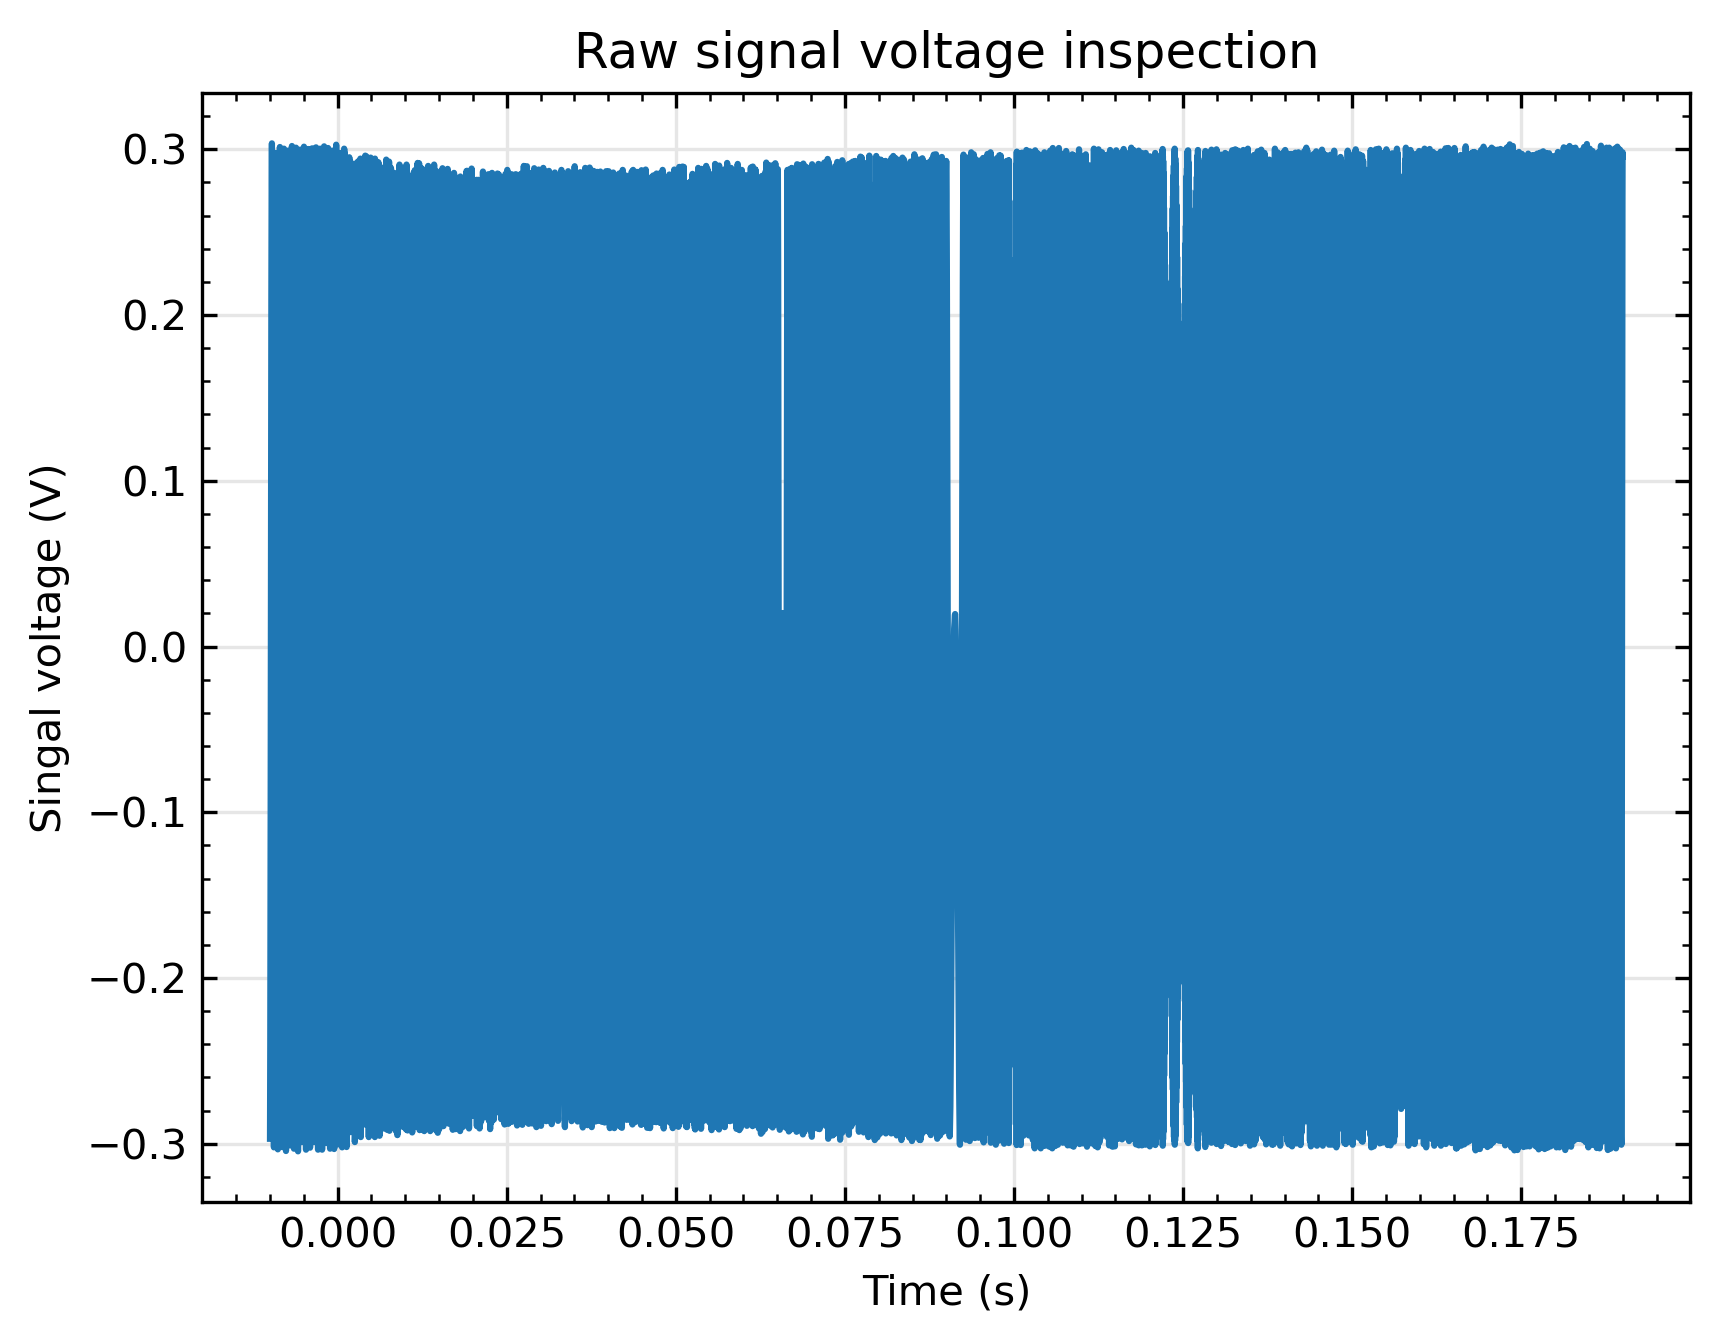

In [6]:
plt.plot(
    v_time[::int(1+len(v_time)/10000)],
    voltage[::int(1+len(voltage)/10000)])

plt.xlabel("Time (s)")
plt.ylabel("Singal voltage (V)")

plt.title("Raw signal voltage inspection")

plt.show()

In [7]:
sample_frequency = 1/np.mean(np.diff(v_time))

with tqdm() as bar:
    idx_time, freqs, amps = hld_tool.scanning_fft(
        voltage, sample_frequency, time_segment, time_step, 
        nfft_power=fft_expand, tqdm_bar=bar)
    
times = v_time[idx_time]

100%|████████████████████████████████████| 19999/19999 [01:44<00:00, 192.17it/s]


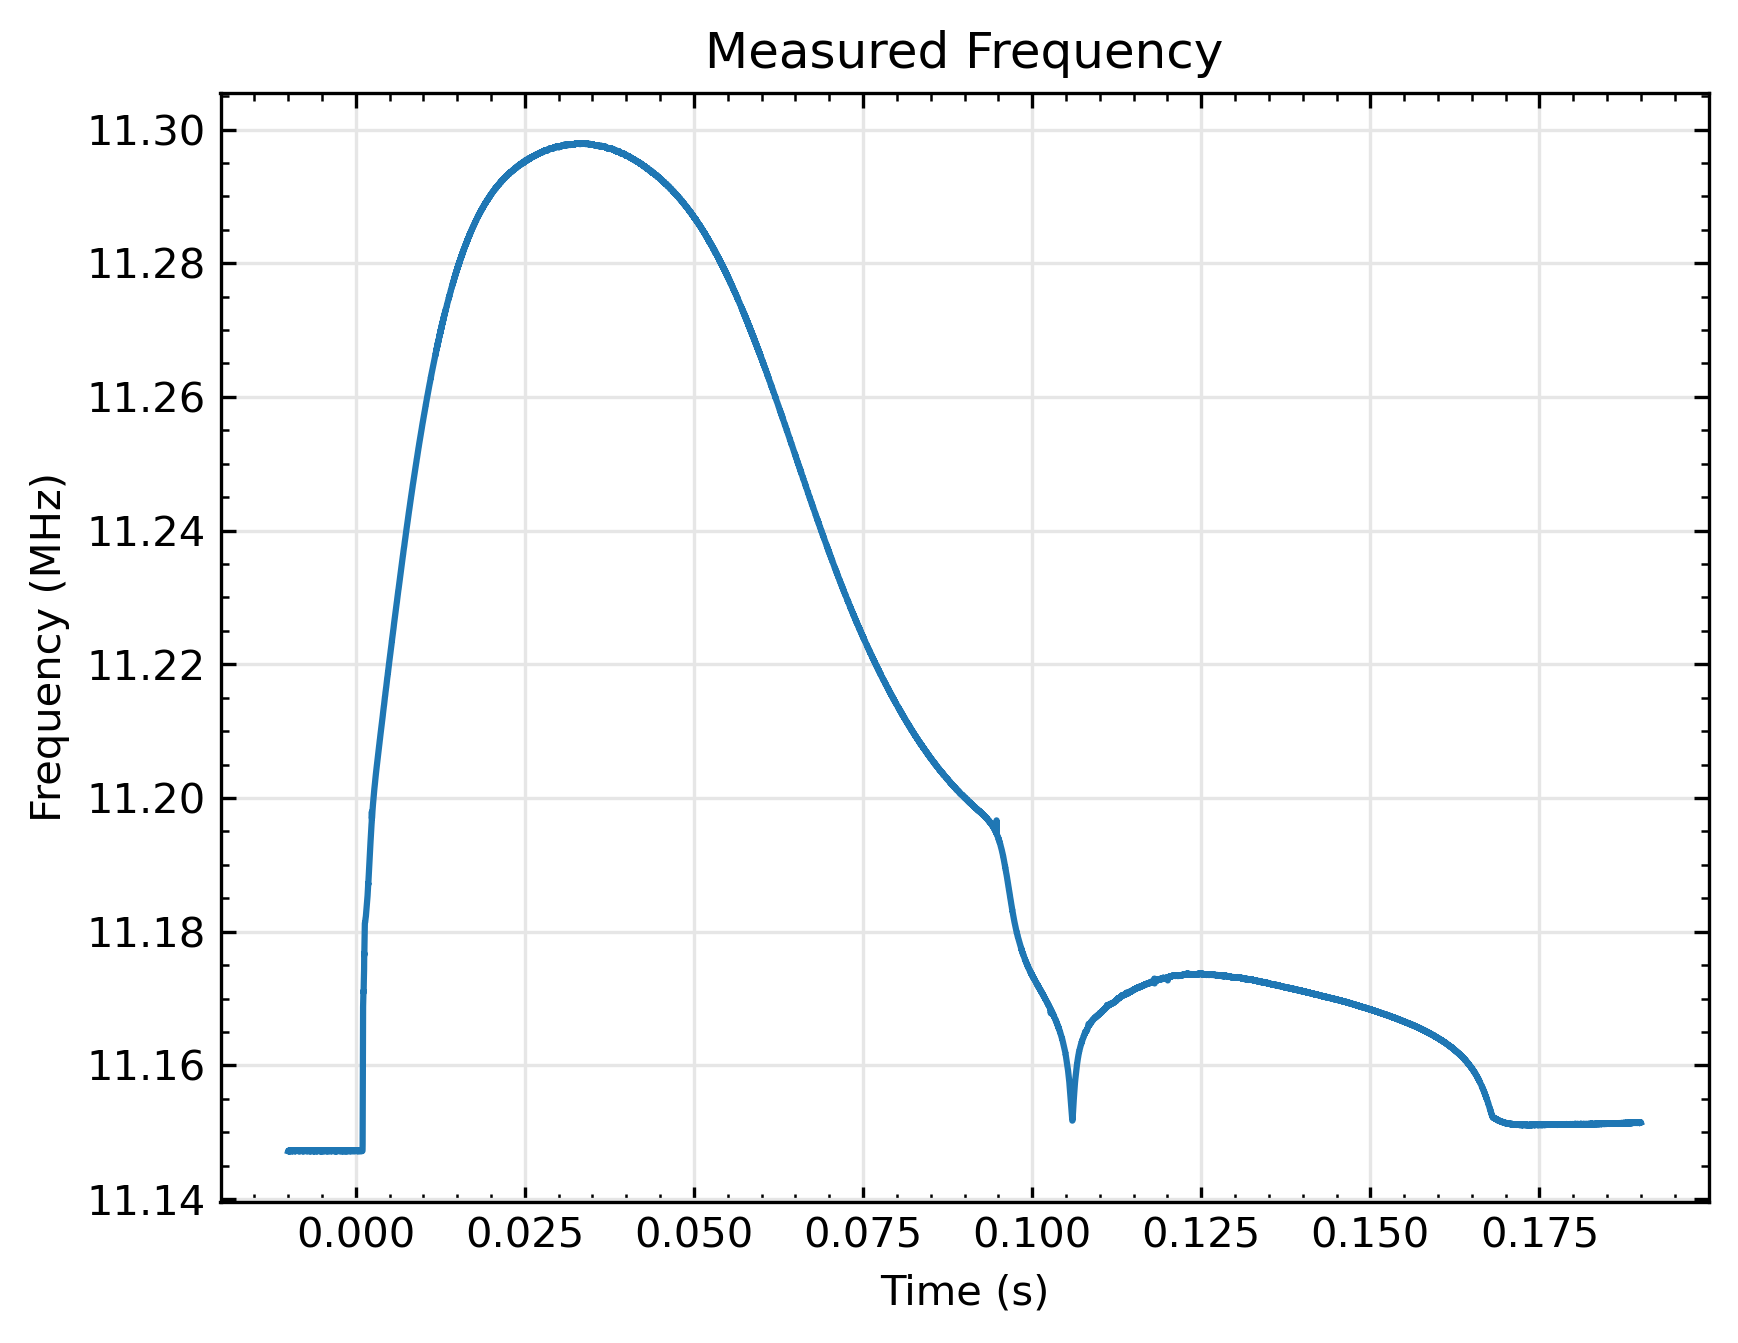

In [8]:
plt.plot(times, freqs*1e-6)

plt.xlabel("Time (s)")
plt.ylabel("Frequency (MHz)")

plt.title("Measured Frequency")

plt.show()


### Get Field Data

In [9]:
pu_time, pickup = pd.read_csv(
    pick_up_filename, 
    header=4, 
    engine=pandas_engine,
    ).values.T

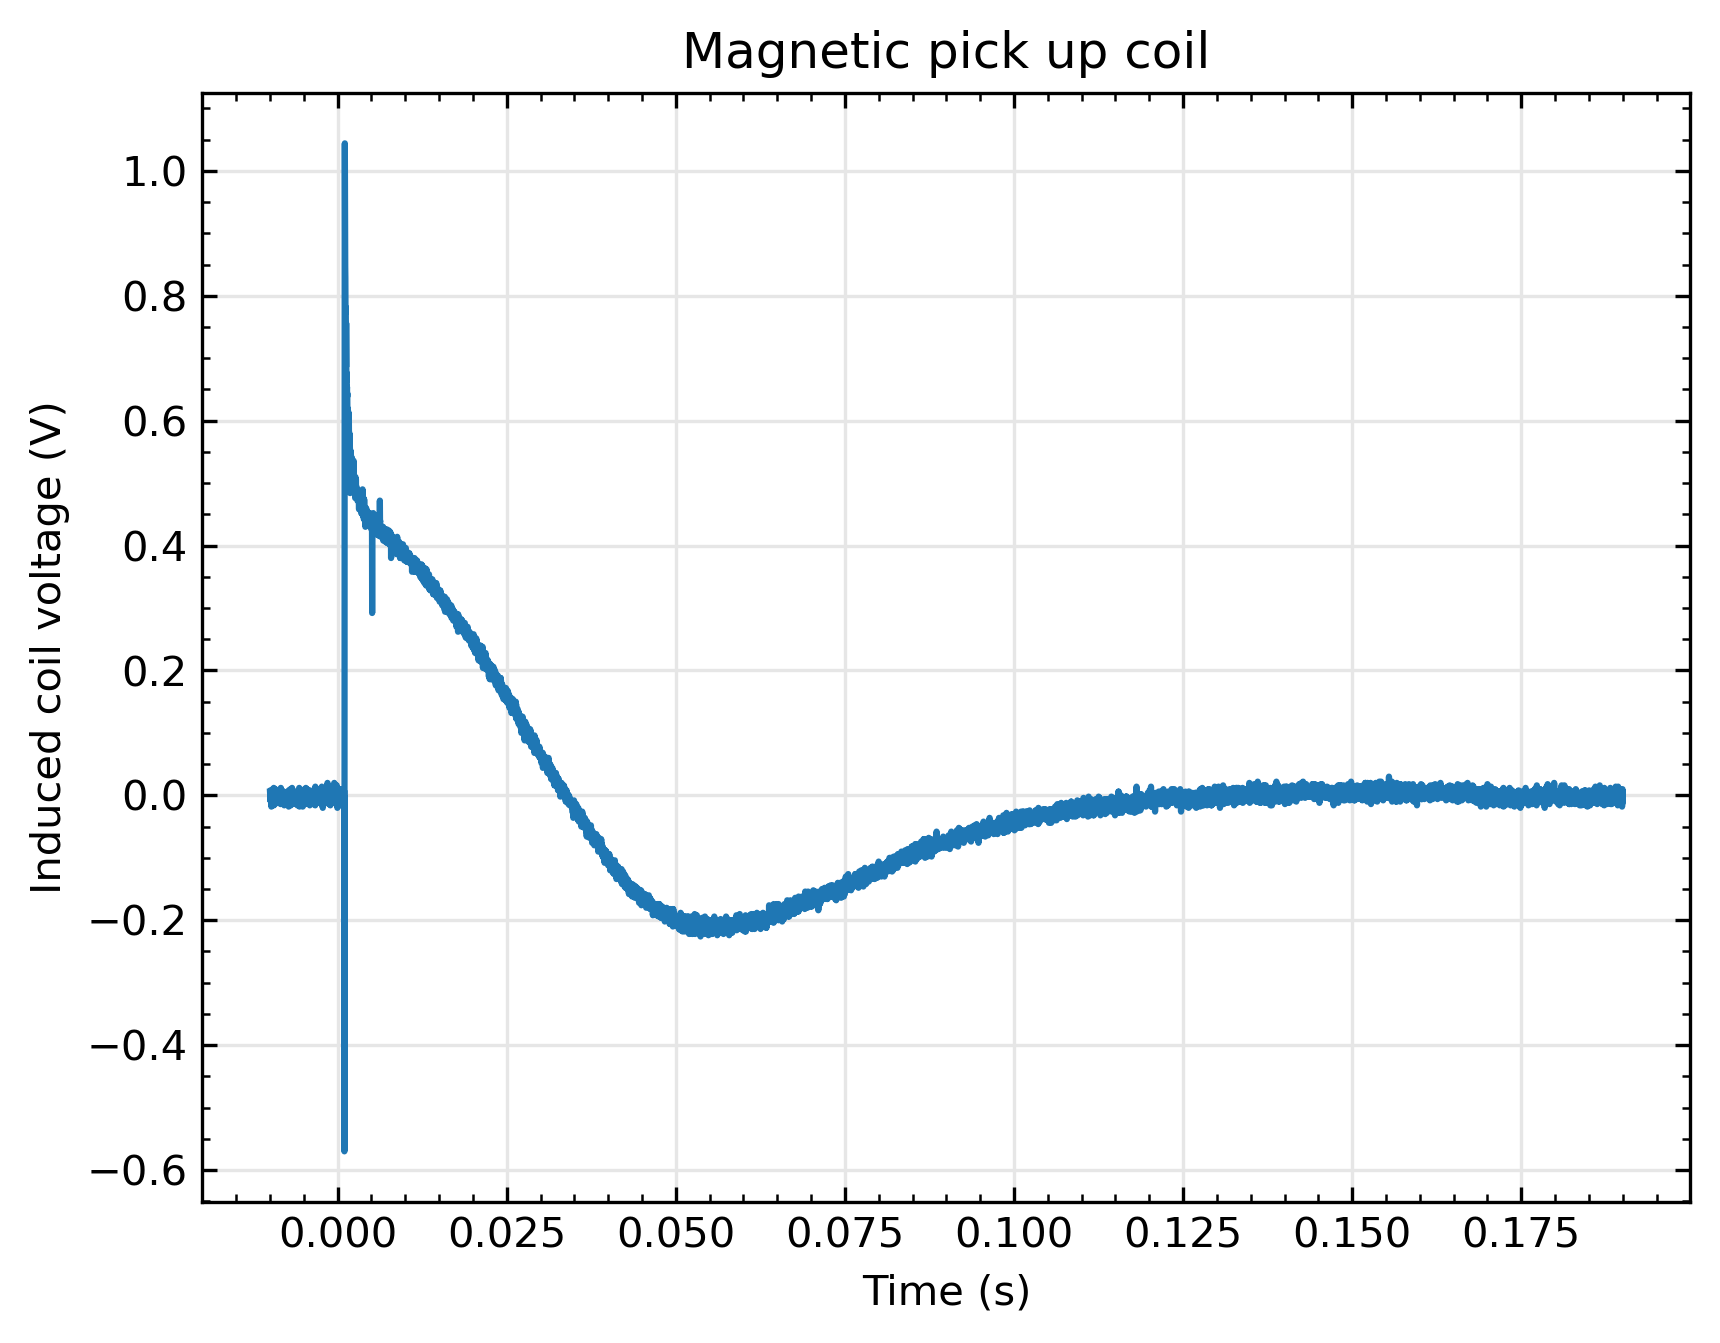

In [10]:
plt.plot(
    pu_time[::int(1+len(pu_time)/10000)],
    pickup[::int(1+len(pickup)/10000)])

plt.xlabel("Time (s)")
plt.ylabel("Induced coil voltage (V)")

plt.title("Magnetic pick up coil")

plt.show()


In [11]:
field_all = hld_tool.PUtoB(pickup, field_factor, 100)
fields = np.interp(times, pu_time, field_all)

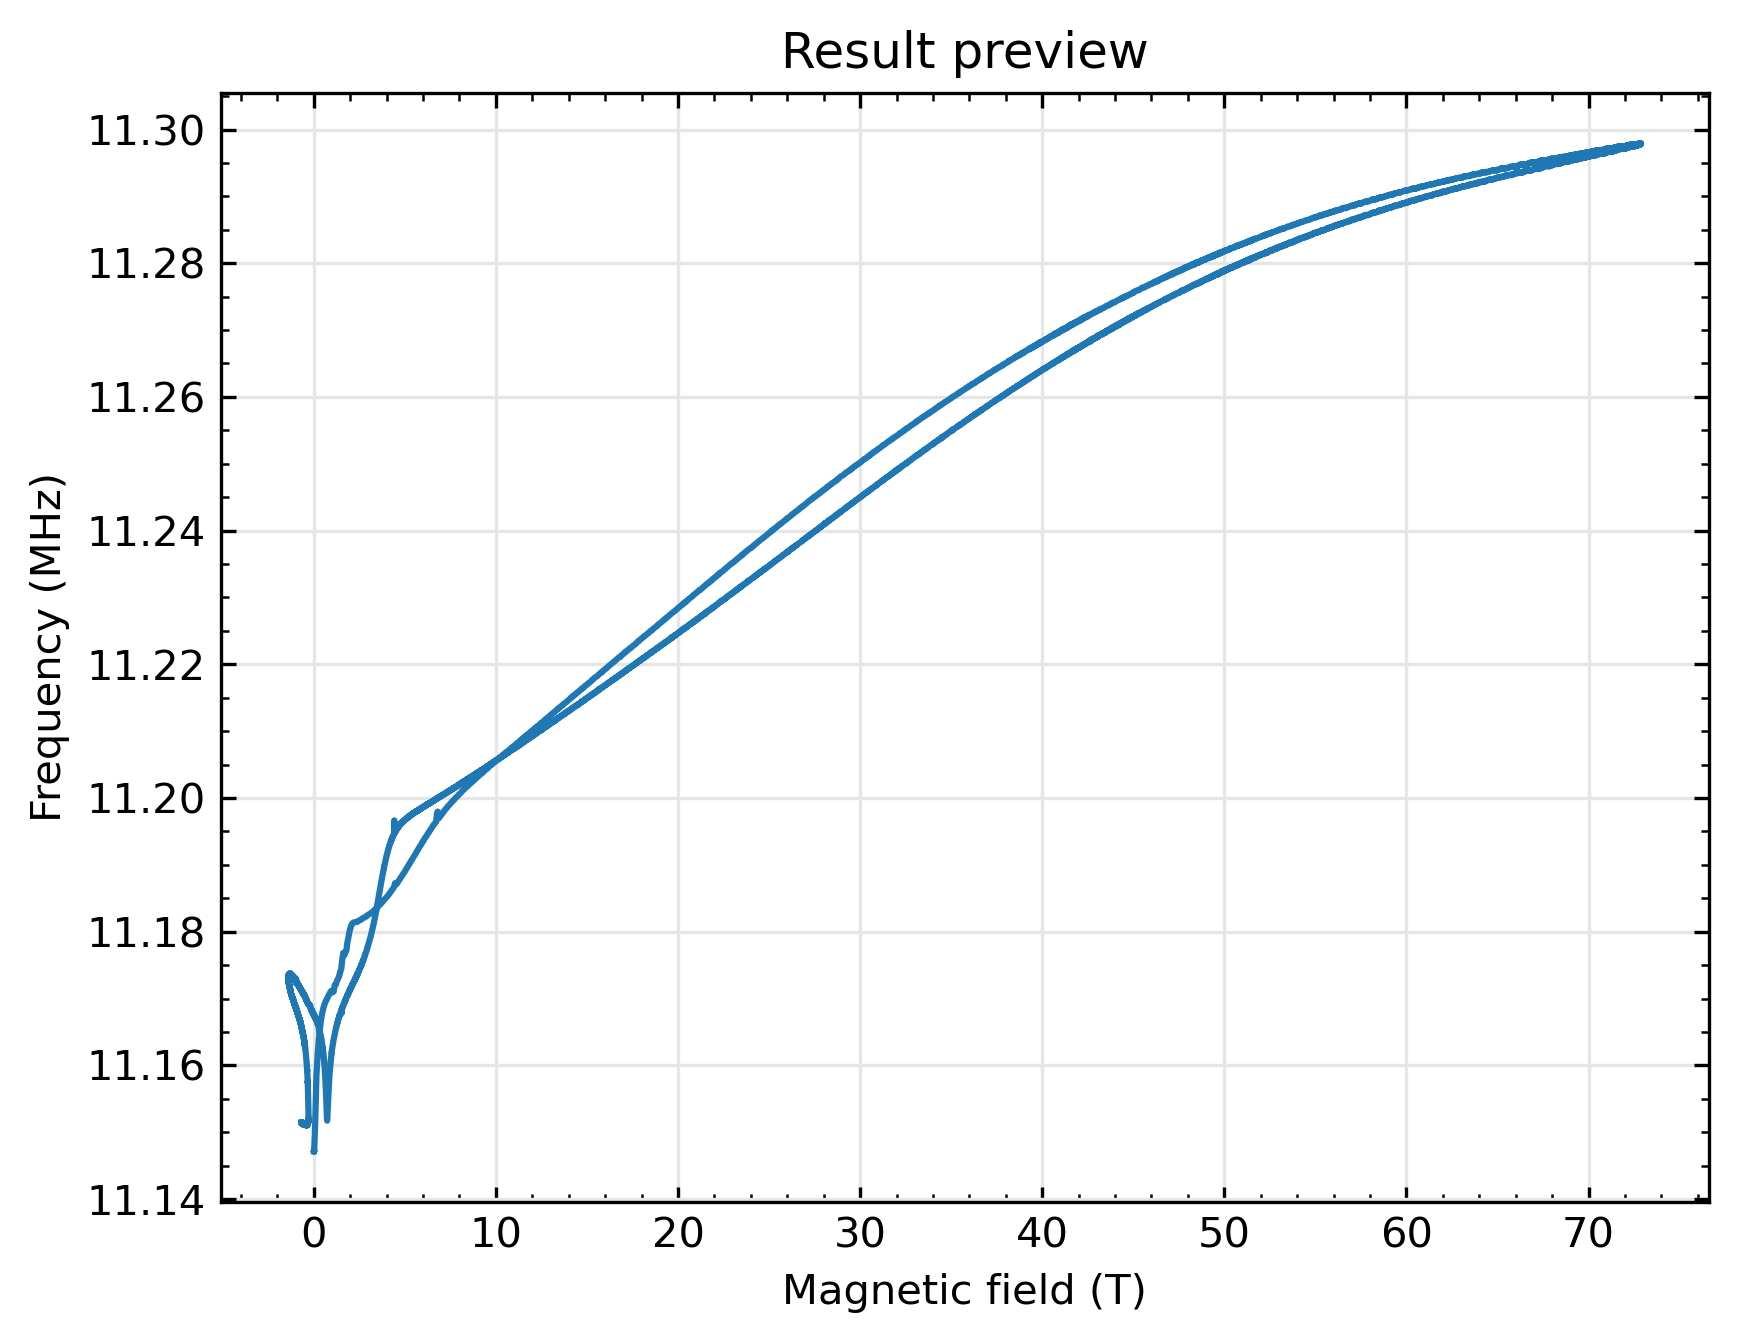

In [12]:
plt.plot(fields, freqs*1e-6)

plt.xlabel("Magnetic field (T)")
plt.ylabel("Frequency (MHz)")

plt.title("Result preview")

plt.show()

### Save the Data to a CSV file

In [13]:
pd.DataFrame({
    "time":times,
    "field":fields,
    "frequency":freqs,
    "amplitude":amps,}).to_csv(output_filename, index=False)